In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
DATASET_DIR = "dataset"  # Your train/test split folder

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = datasets.ImageFolder(root=os.path.join(DATASET_DIR, "train"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(DATASET_DIR, "test"), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Get class names
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}, Total: {num_classes}")


Using device: cpu
Classes: ['1_white', '2_black', '3_asian', '4_latino', '5_nativeamerican', '6_middleeast'], Total: 6


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleVGG(nn.Module):
    def __init__(self, num_classes):
        super(SimpleVGG, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate the model
model = SimpleVGG(num_classes=num_classes).to(device)


In [4]:
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training function
def train_model(model, train_loader, test_loader, epochs=10):
    train_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        test_acc = evaluate_model(model, test_loader)

        train_losses.append(running_loss / len(train_loader))
        test_accuracies.append(test_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    # Plot Accuracy & Loss
    plot_metrics(train_losses, test_accuracies)

    print("Training complete!")

def plot_metrics(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r-', label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, 'b-', label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Test Accuracy over Epochs")
    plt.legend()

    plt.show()
    
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [5]:
train_model(model, train_loader, test_loader, epochs=10)


Epoch [1/10] - Loss: 1.7847, Train Acc: 16.27%, Test Acc: 21.10%
Epoch [2/10] - Loss: 1.6550, Train Acc: 26.18%, Test Acc: 32.11%
Epoch [3/10] - Loss: 1.5861, Train Acc: 33.96%, Test Acc: 38.53%
Epoch [4/10] - Loss: 1.4800, Train Acc: 38.68%, Test Acc: 36.70%
Epoch [5/10] - Loss: 1.4296, Train Acc: 41.04%, Test Acc: 44.95%
Epoch [6/10] - Loss: 1.3908, Train Acc: 42.45%, Test Acc: 50.46%
Epoch [7/10] - Loss: 1.3504, Train Acc: 43.16%, Test Acc: 48.62%
Epoch [8/10] - Loss: 1.3439, Train Acc: 43.63%, Test Acc: 51.38%
Epoch [9/10] - Loss: 1.3177, Train Acc: 49.29%, Test Acc: 49.54%
Epoch [10/10] - Loss: 1.2776, Train Acc: 48.58%, Test Acc: 55.05%
Training complete!


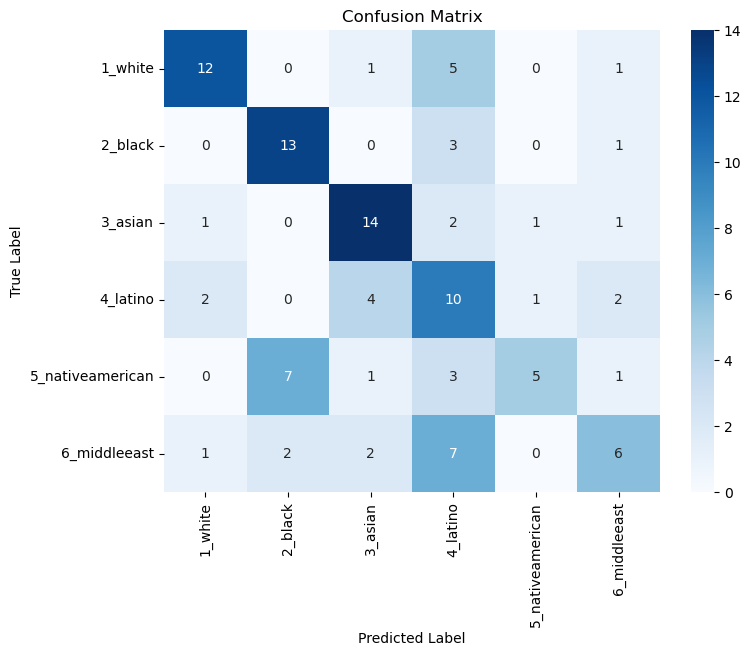

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Call the function after training
plot_confusion_matrix(model, test_loader, class_names)


In [7]:
torch.save(model.state_dict(), "simple_vgg.pth")
print("Model saved as simple_vgg.pth")


Model saved as simple_vgg.pth
